
# Курсовой проект по предсказанию цен на недвижимость


Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):

train.csv

test.csv

Задание:

Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).

С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:

    1. R2 > 0.6
    
    2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
    
    3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
    
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки сдачи:

Cдать проект нужно в течение 72 часов после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

Рекомендации для файла с кодом (ipynb):

    1. Файл должен содержать заголовки и комментарии (markdown)
    
    2. Повторяющиеся операции лучше оформлять в виде функций
    
    3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
    
    4. По возможности добавлять графики, описывающие данные (около 3-5)
    
    5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
    
    6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
    
    7. Весь проект должен быть в одном скрипте (файл ipynb).
    
    8. Допускается применение библиотек Python и моделей машинного обучения,
    которые были в данном курсе.

Описание датасета:

Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

In [516]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [517]:
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.model_selection import cross_val_score , StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
import warnings 
warnings.simplefilter('ignore')

In [518]:
sns.set(rc = {'figure.figsize': (12,8)})
%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 2000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [519]:
train = pd.read_csv('train.csv')

In [520]:
test = pd.read_csv('test.csv')

In [521]:
train = train.set_index('Id')

In [522]:
test = test.set_index('Id')

### Посмотрим на распределение цен.

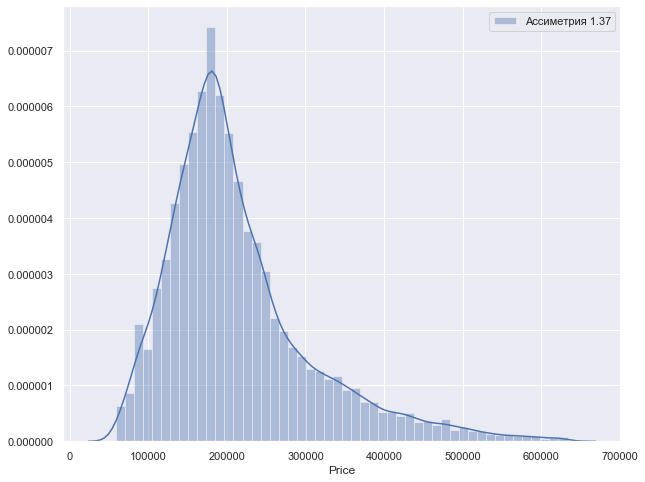

In [523]:
plt.figure(figsize = (10,8))
bar = sns.distplot(train['Price'])
bar.legend([f"Ассиметрия {round(train['Price'].skew(),2)}"])
plt.show()

По этим данным видим что есть у нас хвост по правой стороне, но он не критичный. В дальнейшем сделаем нормальное распределение цены

### Обзор dataset

In [524]:
train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000,10000.000,10000.000,7887.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,5202.000,10000.000,10000.000,10000.000
mean,50.401,1.891,56.316,37.200,6.273,8.527,12.609,3990.166,0.119,24.687,5352.157,8.039,1142.904,1.319,4.231,214138.857
std,43.588,0.840,21.059,86.241,28.561,5.241,6.776,200500.261,0.119,17.533,4006.800,23.832,1021.517,1.494,4.806,92872.294
min,0.000,0.000,1.137,0.371,0.000,1.000,0.000,1910.000,0.000,0.000,168.000,0.000,0.000,0.000,0.000,59174.778
25%,20.000,1.000,41.775,22.770,1.000,4.000,9.000,1974.000,0.018,6.000,1564.000,0.000,350.000,0.000,1.000,153872.634
50%,36.000,2.000,52.513,32.781,6.000,7.000,13.000,1977.000,0.075,25.000,5285.000,2.000,900.000,1.000,3.000,192269.645
75%,75.000,2.000,65.901,45.129,9.000,12.000,17.000,2001.000,0.196,36.000,7227.000,5.000,1548.000,2.000,6.000,249135.462
max,209.000,19.000,641.065,7480.592,2014.000,42.000,117.000,20052011.000,0.522,74.000,19083.000,141.000,4849.000,6.000,23.000,633233.467


Тут у нас есть данные которые не соответсвуют друг другу. Это кухня, жилая площадь, год дома, этажи дома, и количество комнат. 

В дальнейшем исправим все эти недочеты. Сейчас первый взгляд на данные модели. 

#### Уберем неверные данные, которые сразу брасаются в глаза. 

In [525]:
# Все большие данные по площади, все что больше максимальной жилой площади. 
# Это нам поможет на графиках увидеть зависимоть. С этими данными сделать это будет невозможно. 

train.loc[train['LifeSquare']>700,'LifeSquare'] = np.nan
train.loc[train['KitchenSquare']>700,'KitchenSquare'] = np.nan
train.loc[train['HouseYear']>2020,'HouseYear'] = np.nan


### Распределение комнат

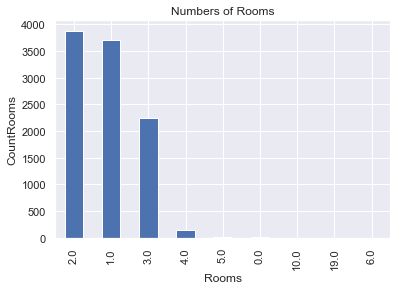

In [526]:
train['Rooms'].value_counts().plot(kind = 'bar')
plt.title('Numbers of Rooms')
plt.xlabel('Rooms')
plt.ylabel('CountRooms')
plt.show()

На этом графике видим , что основная плотность комнат это с 1 по 3. остальные комнаты практически не несут никакой силы предсказания.

### Общая площадь.

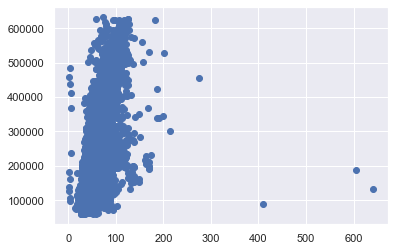

In [527]:
plt.scatter(train['Square'], train['Price'])

Мы видим, что у нас есть квартиры с минимальной площадью и они дороже чем квартиры больше 400 . все остальные квартиры практически рвномерно распределены по стоимости. 

#### Выделим числовые наблюдения и посмотрим просмотрим их на графиках

In [528]:
# переменная для хранения количественных признаков

scat_columns = train.select_dtypes(include = [np.number]).columns

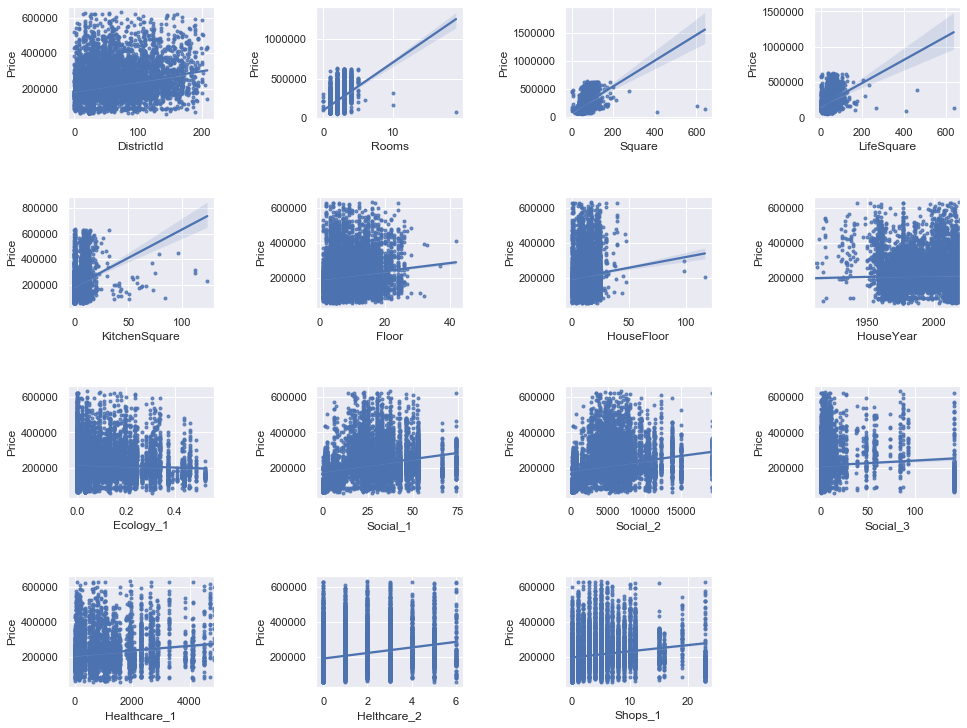

In [529]:

plt.figure(figsize = (16,16))
for i in range(len(scat_columns)-1):
    plt.subplot(5,4,i+1)
    plt.subplots_adjust(hspace = 0.7, wspace = 0.7)
    sns.regplot(data =train, x = scat_columns[i], y = 'Price', marker = '.')

### Карта корреляции признаков 

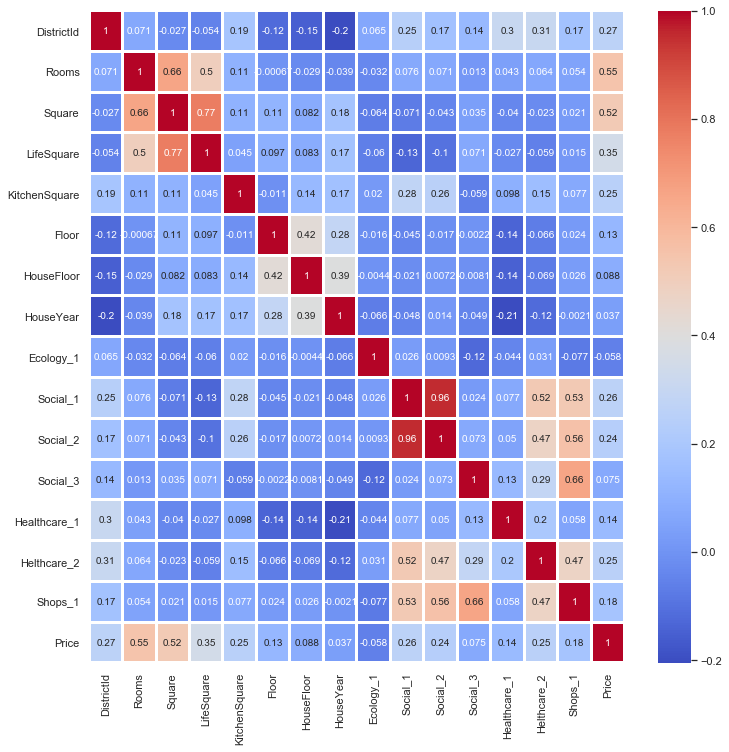

In [530]:
plt.figure(figsize = (12,12))
sns.heatmap(train.corr(), annot = True, cmap = 'coolwarm',linewidth = 2)

#### Выделим признаки которые больше 0.2 относительно цены квартиры. 

В дальнейшим к ним будем обращаться, когда будет идти подбор признаков бля нашей модели.

In [531]:
hig_corr = train.corr()
hig_corr_feats = hig_corr.index[abs(hig_corr['Price'])>=0.2]

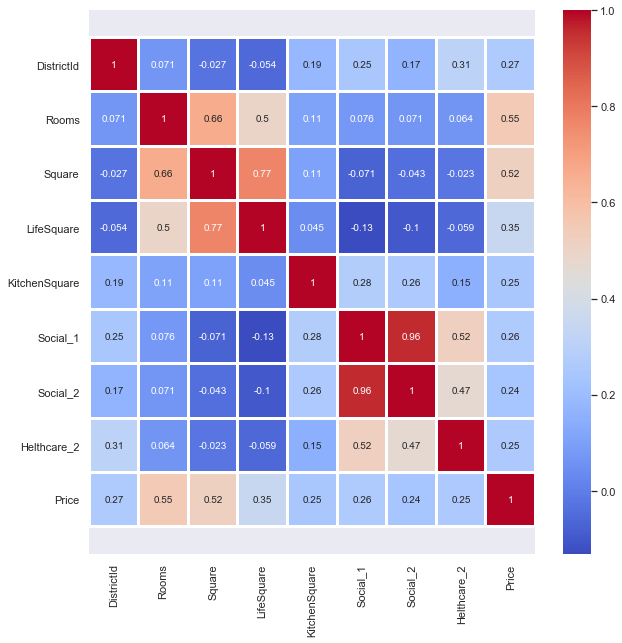

In [532]:
plt.figure(figsize = (10,10))
ax = sns.heatmap(train[hig_corr_feats].corr(), cmap = 'coolwarm', annot = True, linewidth = 2)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top - 0.5)
plt.show()

### Объединение DataSet 

Чтобы писать меньше программного кода, то объеденим их в один

In [533]:
df  = pd.concat((train,test))

# Настрока DataSet

### Объеденим комнаты 

основная масса с 1 по 3 комнату

In [534]:
# Сгруппируем по средней общей площади и количесвту комнат
df.groupby('Rooms').agg({'Square':'median',
                           'Rooms':'count'})

,Square,Rooms
Rooms,,
0.000,78.918,10
1.000,40.327,5474
2.000,55.834,5910
3.000,77.468,3334
4.000,97.358,240
5.000,117.856,25
6.000,110.750,3
10.000,59.964,2
17.000,52.866,1


сделам объединение относительно площади, примерно подбирая к ближайшей.

In [535]:
df.loc[df['Rooms']==0,'Rooms'] = 3
df.loc[df['Rooms']==19,'Rooms'] = 1
df.loc[df['Rooms']==17,'Rooms'] = 2
df.loc[df['Rooms']==10,'Rooms'] = 2
df.loc[df['Rooms']==6,'Rooms'] = 3
df.loc[df['Rooms']==5,'Rooms'] = 3
df.loc[df['Rooms']==4,'Rooms'] = 3

### Пропуски. 

In [536]:
df.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       3155
KitchenSquare       2
Floor               0
HouseFloor          0
HouseYear           2
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     7175
Helthcare_2         0
Shops_1             0
Shops_2             0
Price            5000
dtype: int64

#### Заполним даныне относительно комнат. 

Берем комнату , высчитываем медиану по площадям и заполняем значения Nan 

In [537]:
for i in df['Rooms'].unique():
    mean_valau = df.query('Rooms == @i')['LifeSquare'].median()
    df.loc[(df['Rooms'] == i) & (df['LifeSquare'].isnull()), 'LifeSquare'] = mean_valau

In [538]:
for i in df['Rooms'].unique():
    mean_valau = df.query('Rooms == @i')['KitchenSquare'].median()
    df.loc[(df['Rooms'] == i) & (df['KitchenSquare'].isnull()), 'KitchenSquare'] = mean_valau

Год дома и здравоохранение заполним по моде и медиане. 

In [539]:
df['HouseYear'].fillna(df['HouseYear'].mode(), inplace = True)

In [540]:
df['Healthcare_1'].fillna(df['Healthcare_1'].median(), inplace = True)

## Обработка редких категорий

найдем мелкие частоты и уменьшим их , объединяя в отдельные перменные напрмиер 999

ВАЖНО!!! это делаем только у категориальных признаков. 

я выделил эти наблюдения как категориальные: 

     0   DistrictId - object  
     6   HouseFloor - object  
     7   HouseYear - object 
     9   Ecology_2 - object  
     10  Ecology_3 - object  
     12  Social_2 - object  
     13  Social_3 - object 
     15  Helthcare_2 - object  
     16  Shops_1 - object  
     17  Shops_2 - object

In [541]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.000,47.982,29.443,6.000,7,9.000,1969.000,0.089,B,B,33,7976,5,900.000,0,11,B,184966.931
15053,41,3.000,65.684,40.050,8.000,7,9.000,1978.000,0.000,B,B,46,10309,1,240.000,1,16,B,300009.450
4765,53,2.000,44.948,29.198,0.000,8,12.000,1968.000,0.050,B,B,34,7759,0,229.000,1,3,B,220925.909
5809,58,2.000,53.353,52.732,9.000,8,17.000,1977.000,0.438,B,B,23,5735,3,1084.000,0,5,B,175616.227
10783,99,1.000,39.649,23.776,7.000,11,12.000,1976.000,0.012,B,B,35,5776,1,2078.000,2,4,B,150226.532


### Этаж квартиры

На графике мы видим тенденцию роста относительно большего этажа квартиры. есть конечно сильный выброс, но это вожножно ошибочно

введенные данные

Данное наблюдение у нас будет количественным. есть рост стомости относительно увеличение числа от 0 ----> 40

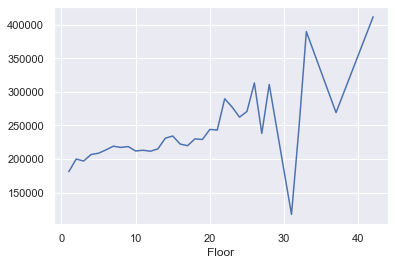

In [542]:
train.groupby('Floor')['Price'].mean().plot()
plt.show()

In [543]:
train.groupby('Floor').agg({'Floor':'count',
                           'Price':'median'}).tail(10)

,Floor,Price
Floor,,
24,53,245736.934
25,34,217451.999
26,18,276618.475
27,5,211498.638
28,3,333862.631
31,1,117647.461
32,2,245640.189
33,1,389554.064
37,1,269113.584


In [544]:
df.groupby('Floor').agg({'Floor':'count',
                           }).tail(10)

,Floor
Floor,
28,4
31,2
32,4
33,2
34,1
37,1
38,1
42,1
46,1


Смотря на срежнюю стоимоть этажа, на общем DataSet мы переносим квартиры на дргуие этажи. 

Тут мы избавляемся от мелких частот и еще примерно переносим все отноистельно стоимости этажа. 

In [545]:
df.loc[df['Floor']==42,'Floor'] = 22
df.loc[df['Floor']==37,'Floor'] = 24
df.loc[df['Floor']==33,'Floor'] = 22
df.loc[df['Floor']==32,'Floor'] = 21
df.loc[df['Floor']==31,'Floor'] = 1
df.loc[df['Floor']==28,'Floor'] = 22
df.loc[df['Floor']==27,'Floor'] = 20
df.loc[df['Floor']==34,'Floor'] = 21
df.loc[df['Floor']==38,'Floor'] = 22
df.loc[df['Floor']==46,'Floor'] = 22
df.loc[df['Floor']==78,'Floor'] = 24

###  Этаж дома

Стоимоть распредленеа беспорядочно, показывает что нет зависимоти от этажности знания. 

Данное наблюдение мы будем считать как категорильную  и сделаме объединение по частотам.

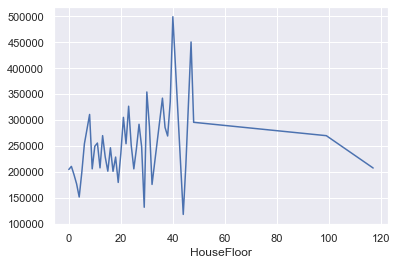

In [546]:
train.groupby('HouseFloor')['Price'].mean().plot()
plt.show()

In [547]:
df.groupby('HouseFloor').agg({'HouseFloor':'count'}).tail()

,HouseFloor
HouseFloor,
45.000,1
47.000,1
48.000,5
99.000,3
117.000,1


все дома меньше частоты 10 переводимм в категорию 999 

In [548]:
df.loc[df['HouseFloor'].value_counts()[df['HouseFloor']].values < 10,  
         'HouseFloor'] = 999

Сразу сделаем новую фичу , это этажность здания. 

In [549]:
bins = [-np.inf, 5, 12, np.inf]
group_names = ['Малоэтажка', 'Средний дома', 'Многоэтажка']
df['HouseFloor_DUM'] = pd.cut(df['HouseFloor'], bins, labels=group_names)

### Год дома

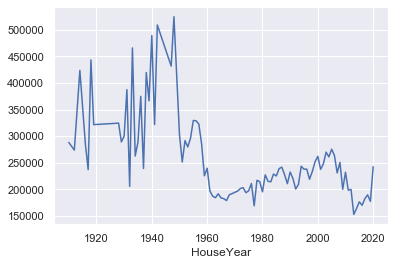

In [550]:
train.groupby('HouseYear')['Price'].median().plot()
plt.show()

На графике мы видим, что дома которые до 1960 года стоят дороже чем каджый дом после 1960. 

Можно сразу все эти дома первести в один год и будет он 1959.

мы тоже считаем это категорильной перменной , нос частотой не будем ничего делать. Мы уже перевели много домов в 1959 год

In [551]:
train.loc[train['HouseYear']<1960,'HouseYear'] = 1959

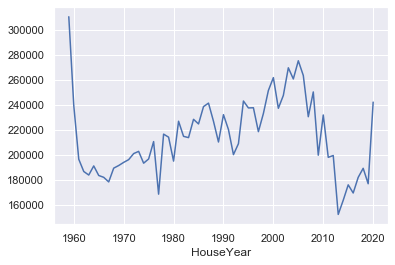

In [552]:
train.groupby('HouseYear')['Price'].median().plot()
plt.show()

In [553]:
df.groupby('HouseYear').agg({'HouseYear':'count'}).tail()

,HouseYear
HouseYear,
2016.000,477
2017.000,449
2018.000,248
2019.000,107
2020.000,28


Тоже самое продедлаем на нашем основнов DataSet

In [554]:
df.loc[df['HouseYear']<1960,'HouseYear'] = 1959

In [555]:
df['HouseYear'].fillna(df['HouseYear'].mode()[0],inplace = True)

Создалим новое наблюдение по возрасту дома. 

In [556]:
bins = [-np.inf, 1960, 2000, np.inf]
group_names = ['Old', 'Mid', 'Young']
df['HouseYear_DUM'] = pd.cut(df['HouseYear'], bins, labels=group_names)

### Социалка

#### Social_2

Зависимоти нет по стоимости , делаем уменьшение категории по частотам и переведем в категориальную перменную. 

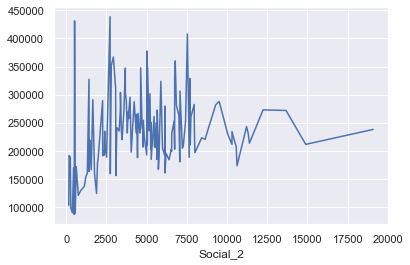

In [557]:
train.groupby('Social_2')['Price'].mean().plot()
plt.show()

In [558]:
df.groupby('Social_2').agg({'Social_2':'count'}).tail()

,Social_2
Social_2,
11395,144
12238,112
13670,315
14892,235
19083,265


все наблюдения частотой меньше 10 переводим в категорию 999 

In [559]:
df.loc[df['Social_2'].value_counts()[df['Social_2']].values < 10,  
         'Social_2'] = 999

#### Social_3

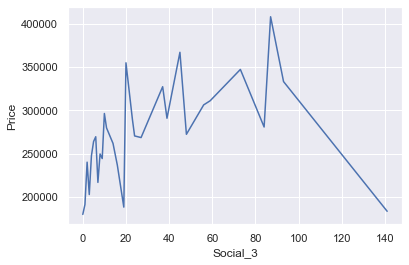

In [560]:
train.groupby('Social_3')['Price'].mean().plot()
plt.ylabel('Price')
plt.show()

In [561]:
df.groupby('Social_3').agg({'Social_3':'count'}).tail()

,Social_3
Social_3,
73,19
84,75
87,37
93,37
141,365


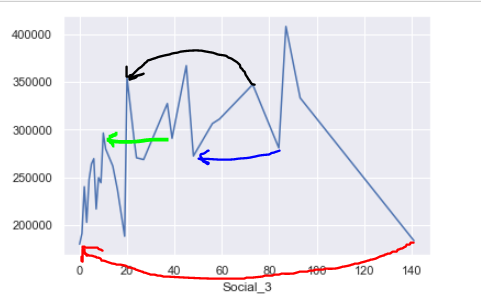

Объеденим вершины относительно одинакоквой стоимости в меньшую категорию 

например 141 перейдем в 0 , так как стоимоть приэтих категориях одинаковая 

тоже самое проделаем с остальными категориями 

In [562]:
df.loc[df['Social_3']==141,'Social_3'] = 0
df.loc[df['Social_3']==84,'Social_3'] = 48
df.loc[df['Social_3']==73,'Shops_1'] = 42
df.loc[df['Social_3']==39,'Shops_1'] = 11

### Здравоохранение

#### Healthcare_1

Что с этой категорие делать не известно. изначально было 50% пропусков. Возможно она на в дальнейшем и не пригодится, но так же сделам объединение по мелким категориям 

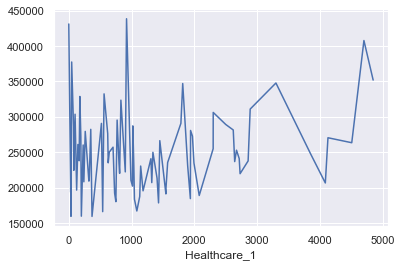

In [563]:
train.groupby('Healthcare_1')['Price'].mean().plot()
plt.show()


In [564]:
df.groupby('Healthcare_1').agg({'Healthcare_1':'count'}).tail()

,Healthcare_1
Healthcare_1,
4087.000,66
4129.000,57
4508.000,71
4702.000,37
4849.000,28


In [565]:
df.loc[df['Healthcare_1'].value_counts()[df['Healthcare_1']].values < 10,  
         'Healthcare_1'] = 30

#### Helthcare_2

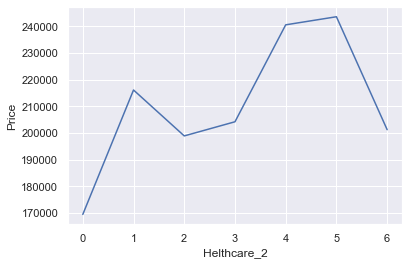

In [566]:
train.groupby('Helthcare_2')['Price'].median().plot()
plt.ylabel('Price')
plt.show()

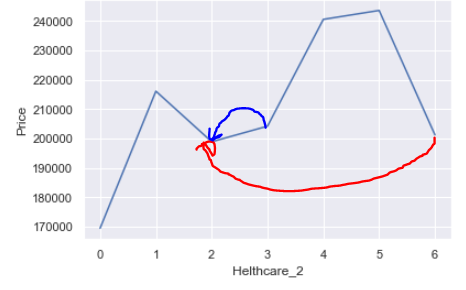

Сделаем тоже самое преобразование, что мы делали на Socila_3. Объеденим категории относительно стоимости. Количество категория йнам это позволяем сделать

In [567]:
df.loc[df['Helthcare_2']==6,'Helthcare_2'] = 2
df.loc[df['Helthcare_2']==3,'Helthcare_2'] = 2

### Магазины

Аналогичный способ заполнения что и предыдущий

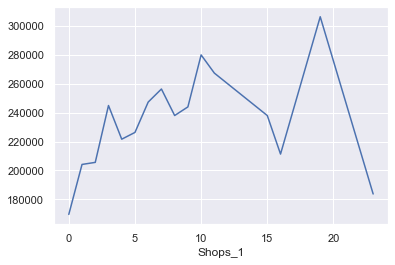

In [568]:
train.groupby('Shops_1')['Price'].mean().plot()
plt.show()

In [569]:
df.groupby('Shops_1').agg({'Shops_1':'count'}).tail()

,Shops_1
Shops_1,
15,265
16,122
19,68
23,365
42,19


In [570]:
df.loc[df['Shops_1']==23,'Shops_1'] = 0
df.loc[df['Shops_1']==16,'Shops_1'] = 5
df.loc[df['Shops_1']==9,'Shops_1'] = 3

### Районы 

Распределение районов по смтоимоть не дает никакой информации, тут мы объеденим их в одну группу 999

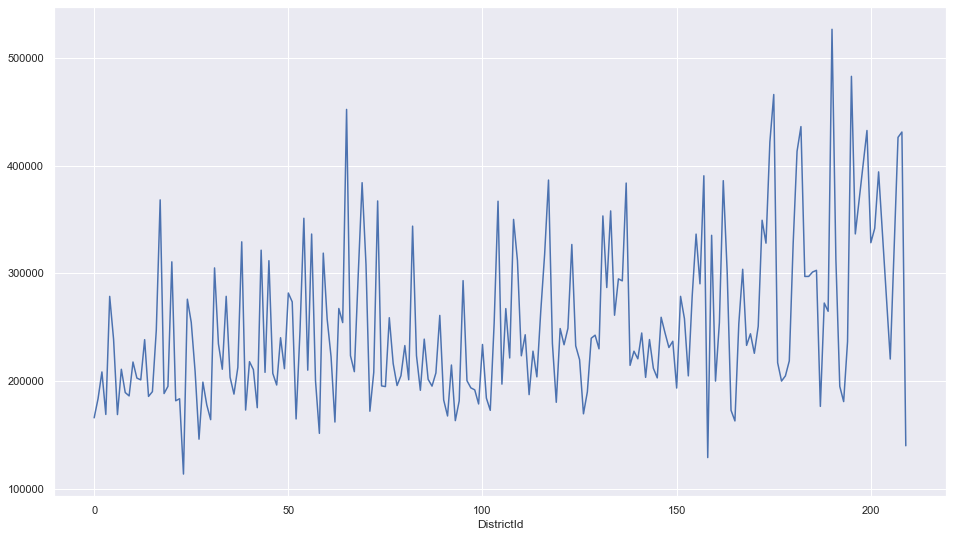

In [571]:
plt.figure(figsize = (16,9))
train.groupby('DistrictId')['Price'].median().plot()
plt.show()

In [572]:
df['DistrictId'].value_counts().tail(10)

210    1
199    1
203    1
211    1
204    1
212    1
117    1
174    1
198    1
207    1
Name: DistrictId, dtype: int64

Все что меньше частоты 10, уходит в 999

In [573]:
df.loc[df['DistrictId'].value_counts()[df['DistrictId']].values < 10,  
         'DistrictId'] = 999

In [574]:
df['PriceDist'] = np.nan

передадими для каждого дистрикта метку, в какойм диапозоне цены он находится 

In [575]:
for i in train['DistrictId'].unique():
    mean_price = df.query('DistrictId==@i')['Price'].median()
    if mean_price< 200000:
        df.loc[(df['DistrictId'] == i) & (df['PriceDist'].isnull()),'PriceDist'] = 'Mininal'
    elif 300000>mean_price>=200000:
        df.loc[(df['DistrictId'] == i) & (df['PriceDist'].isnull()),'PriceDist'] = 'Mean'
    elif 300000<=mean_price<400000:
        df.loc[(df['DistrictId'] == i) & (df['PriceDist'].isnull()),'PriceDist'] = 'Maximum'
    elif mean_price>=400000:
        df.loc[(df['DistrictId'] == i) & (df['PriceDist'].isnull()),'PriceDist'] = 'BIGPrice'

In [576]:
df['PriceDist'].fillna(df['PriceDist'].mode()[0], inplace = True)

### Экология

In [577]:
df['Ecology_1'].value_counts().head(10)

0.007    884
0.000    816
0.243    768
0.072    714
0.076    501
0.000    365
0.070    315
0.162    288
0.035    282
0.091    265
Name: Ecology_1, dtype: int64

Видим интересную картиру, нулевых значений у нас два раза повторяется. округлим до двух знаков после запятой

In [578]:
df['Ecology_1'] =round(df['Ecology_1'],2)

In [579]:
df['Ecology_1'].value_counts().head(10)

0.010    1797
0.000    1735
0.070    1176
0.040    1059
0.240     934
0.080     610
0.050     596
0.030     583
0.090     573
0.130     478
Name: Ecology_1, dtype: int64

Тепер распределение больше похоже на правду

### Переведем площадь в int и надем одинаковые данные 

Переведем все в int И найдем одинаковы площади у квартиры. если площадь жилая или кухня равно общей, то  переводим в NaN

In [580]:
for i in ['Square','LifeSquare','KitchenSquare']:
    df[i] = df[i].astype(int)

In [581]:
df[['Square','LifeSquare','KitchenSquare']].head()

,Square,LifeSquare,KitchenSquare
Id,,,
14038,47,29,6
15053,65,40,8
4765,44,29,0
5809,53,52,9
10783,39,23,7


In [582]:
df.loc[df['Square'] == df['LifeSquare'], 'LifeSquare'] = np.nan

In [583]:
df.loc[df['Square'] == df['KitchenSquare'],'KitchenSquare'] = np.nan

In [584]:
df.loc[df['LifeSquare'] == df['KitchenSquare'], 'KitchenSquare'] = np.nan

In [585]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000,15000.000,15000.000,14686.000,14911.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,10000.000
mean,63.992,1.876,55.860,34.098,5.878,8.536,15.608,1984.997,0.119,24.769,5370.696,4.503,1027.374,1.114,3.455,214138.857
std,125.838,0.768,20.421,17.561,6.879,5.226,55.516,17.838,0.119,17.532,4013.006,10.317,753.338,1.257,3.791,92872.294
min,0.000,1.000,1.000,0.000,0.000,1.000,0.000,1959.000,0.000,0.000,168.000,0.000,30.000,0.000,0.000,59174.778
25%,20.000,1.000,41.000,21.000,1.000,4.000,9.000,1974.000,0.020,6.000,1564.000,0.000,830.000,0.000,0.000,153872.634
50%,37.000,2.000,52.000,32.000,6.000,7.000,12.000,1977.000,0.080,25.000,5285.000,1.000,900.000,1.000,3.000,192269.645
75%,76.000,2.000,66.000,43.000,9.000,12.000,17.000,2001.000,0.200,36.000,7287.000,4.000,990.000,2.000,5.000,249135.462
max,999.000,3.000,641.000,638.000,620.000,26.000,999.000,2020.000,0.520,74.000,19083.000,93.000,4849.000,5.000,42.000,633233.467


#### Выбросы по кухне. 

проверим все возможные несоответвия по бизнес-логике. 

Площадь кухни не равно жилой или общей, (жилай площадь + кухня) больше чем общая и т.д

всеэти данный переведем в NaN

In [586]:
df.loc[df['KitchenSquare']>df['Square'],'KitchenSquare'] = np.nan

In [587]:
df.loc[df['KitchenSquare']>df['LifeSquare'],'KitchenSquare'] = np.nan


In [588]:
df.loc[df['KitchenSquare']>10,'KitchenSquare'] = np.nan

In [589]:
df.loc[df['KitchenSquare']>43,'KitchenSquare'] = np.nan

In [590]:
df.loc[(df['KitchenSquare'] == 0) | (df['KitchenSquare'] == 1),'KitchenSquare' ] = np.nan

#### Выбросы жилая площадь

In [591]:
df.loc[df['LifeSquare']>df['Square'], 'LifeSquare'] = np.nan

In [592]:
df.loc[df['LifeSquare']==0, 'LifeSquare'] = np.nan

In [593]:
df.loc[df['LifeSquare']==1, 'LifeSquare'] = np.nan

In [594]:
df.loc[df['LifeSquare']<10, 'LifeSquare'] = np.nan

#### Выбросы Площадь. 

все квартиры меньше 10 переведем в NaN

In [595]:
df.loc[df['Square']<10,'Square'] = np.nan

# Заполнение пропусков 

In [596]:
df.isnull().sum()

DistrictId           0
Rooms                0
Square              20
LifeSquare        1197
KitchenSquare     5774
Floor                0
HouseFloor           0
HouseYear            0
Ecology_1            0
Ecology_2            0
Ecology_3            0
Social_1             0
Social_2             0
Social_3             0
Healthcare_1         0
Helthcare_2          0
Shops_1              0
Shops_2              0
Price             5000
HouseFloor_DUM       0
HouseYear_DUM        0
PriceDist            0
dtype: int64

Опять все заполняем относительно количесвтва комнат

In [597]:
for value in ['Square','LifeSquare', 'KitchenSquare']:
    for i in df['Rooms'].unique():
        mean_valau = df.query('Rooms == @i')[value].median()
        df.loc[(df['Rooms'] == i) & (df[value].isnull()), value] = mean_valau

# Категориальные признаки

In [598]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseFloor_DUM,HouseYear_DUM,PriceDist
Id,,,,,,,,,,,,,,,,,,,,,,
14038,35,2.000,47.000,29.000,6.000,7,9.000,1969.000,0.090,B,B,33,7976,5,900.000,0,11,B,184966.931,Средний дома,Mid,Mean
15053,41,3.000,65.000,40.000,8.000,7,9.000,1978.000,0.000,B,B,46,10309,1,240.000,1,5,B,300009.450,Средний дома,Mid,Mean
4765,53,2.000,44.000,29.000,7.000,8,12.000,1968.000,0.050,B,B,34,7759,0,229.000,1,3,B,220925.909,Средний дома,Mid,Mean
5809,58,2.000,53.000,52.000,9.000,8,17.000,1977.000,0.440,B,B,23,5735,3,1084.000,0,5,B,175616.227,Многоэтажка,Mid,Mininal
10783,99,1.000,39.000,23.000,7.000,11,12.000,1976.000,0.010,B,B,35,5776,1,2078.000,2,4,B,150226.532,Средний дома,Mid,Mininal


как уже пиcал выше, выбраны категориальные признаки для нашего DataSet

In [599]:
column_for_dum = ['DistrictId','HouseFloor','Social_2', 'Shops_1','Helthcare_2','Social_3','HouseYear']

In [600]:
for i in column_for_dum:
    df[i] = df[i].astype('object')

In [601]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 14038 to 12504
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   DistrictId      15000 non-null  object  
 1   Rooms           15000 non-null  float64 
 2   Square          15000 non-null  float64 
 3   LifeSquare      15000 non-null  float64 
 4   KitchenSquare   15000 non-null  float64 
 5   Floor           15000 non-null  int64   
 6   HouseFloor      15000 non-null  object  
 7   HouseYear       15000 non-null  object  
 8   Ecology_1       15000 non-null  float64 
 9   Ecology_2       15000 non-null  object  
 10  Ecology_3       15000 non-null  object  
 11  Social_1        15000 non-null  int64   
 12  Social_2        15000 non-null  object  
 13  Social_3        15000 non-null  object  
 14  Healthcare_1    15000 non-null  float64 
 15  Helthcare_2     15000 non-null  object  
 16  Shops_1         15000 non-null  object  
 17  Shops_2 

# Логарифмирование

Сделаем нормальизацию количественных наблюдений

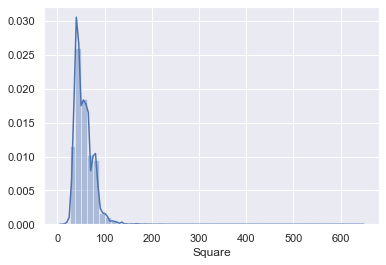

In [602]:
sns.distplot(df['Square'])
plt.show()

In [603]:
# переменная для количественных переменных
for_log = df.select_dtypes(include = [np.number]).columns

In [604]:
for_log

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1',
       'Social_1', 'Healthcare_1', 'Price'],
      dtype='object')

In [605]:
# Сделам номмализацию по нашим данным.
for i in for_log:
    df[i] = np.log(df[i]+1)

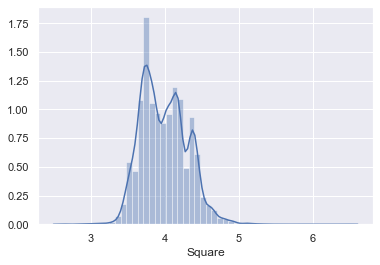

In [606]:
sns.distplot(df['Square'])
plt.show()

#### Нормализация цены

In [607]:
SalePrice = np.log(train['Price']+1)

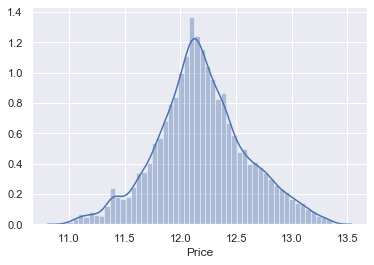

In [608]:
sns.distplot(SalePrice)
plt.show()

## Сделаем бекап нашего DS

In [609]:
df.to_csv('final_df.csv')

### Загрузка DF

In [610]:
data = pd.read_csv('final_df.csv')
data = data.set_index('Id')
Price = train[['Price']]

In [611]:
column_for_dum = ['DistrictId','HouseFloor','Social_2', 'Shops_1','Helthcare_2','Social_3','HouseYear']

In [612]:
for i in column_for_dum:
    data[i] = data[i].astype('object')

#### Фитчи для отбора

In [613]:
feature = [
    'DistrictId',
          'Rooms',
          'Square',
           'LifeSquare',
           'KitchenSquare',
          'Floor',
         'HouseFloor',
        'HouseYear',
          #'Ecology_1',
          #'Ecology_2',
          #'Ecology_3',
          'Social_1',
          'Social_2',
          #'Social_3',
          #'Healthcare_1',
          'Helthcare_2',
          #'Shops_1',
           #'Shops_2',
          'HouseFloor_DUM',
          'HouseYear_DUM',
          'PriceDist'
]

#### Подготовка

In [614]:
data = data[feature]

Перемеведм все категориальные перменные в dummies

In [615]:
data = pd.get_dummies(data)

In [616]:
data.shape

(15000, 412)

### Масштабируем объекты

In [617]:
scaler = RobustScaler()
scaler.fit(data)
df_new = scaler.transform(data)

#### Разбиваем на тренировочную и тестовую модель

In [618]:
X_train = df_new[:len(train)]
X_test = df_new[len(train):]


In [619]:
y_train = SalePrice

In [620]:
X_train.shape

(10000, 412)

In [621]:
X_test.shape

(5000, 412)

# Модель

Напишим функцию для удобства проверки моделей обучения.

Было использовано  примерно 10 моделеий обучения, но по моей логике лучший результат выдавал результат SVM( SVR и nuSVR) 

# Тестирование модели на cross_val_score

In [622]:
def score_model(model, X_train = X_train, y_train = y_train):
    cv = KFold(n_splits = 3, shuffle = True, random_state = 42)
    r2 = make_scorer(r2_score)
    r2_vale_score = cross_val_score(model, X_train, y_train, cv = cv, scoring = r2)
    
    return f'R2 : {r2_vale_score.mean()}'

### NuSVR

In [623]:
nuSVR = NuSVR(cache_size=1000, nu =0.4, C=1)

In [624]:
nuSVR

NuSVR(C=1, cache_size=1000, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.4, shrinking=True, tol=0.001, verbose=False)

In [625]:
score_model(nuSVR)

'R2 : 0.7241819912779218'

In [626]:
nuSVR.fit(X_train, y_train)
y_pred_nuSVR = np.exp(nuSVR.predict(X_test)).round(2)

In [627]:
preds = pd.DataFrame()
preds['Id'] = test.index
preds['Price'] = y_pred_nuSVR

In [628]:
preds = preds.set_index('Id')

In [629]:
preds.to_csv('Mishkin_Kirill_predictions.csv')